In [ ]:
import os
import numpy as np
from PIL import Image

def load_and_preprocess_images(low_res_dir, high_res_dir):
    file_names = os.listdir(low_res_dir)

    lr_images, hr_images = [], []
    for file_name in file_names:
        low_res_path = os.path.join(low_res_dir, file_name)
        high_res_path = os.path.join(high_res_dir, file_name)

        #Gray Scale Transformation
        lr_image = Image.open(low_res_path).convert("L")
        hr_image = Image.open(high_res_path).convert("L")

        lr_images.append(np.array(lr_image).astype(np.float32) )
        hr_images.append(np.array(hr_image).astype(np.float32) )


    lr_images = np.expand_dims(lr_images, axis=-1)
    hr_images = np.expand_dims(hr_images, axis=-1)

    return lr_images, hr_images
    return lr_images, hr_images


In [ ]:
import os
import numpy as np
from tensorflow.keras.layers import Conv2D, PReLU, Conv2DTranspose, Input, Dropout, Add, BatchNormalization, Resizing, UpSampling2D
from keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
import matplotlib.pyplot as plt


###**model1**

In [ ]:
def fsrcnn(input_shape):
    inputs = Input(input_shape)

    # Feature extraction
    x = Conv2D(256, (5, 5), padding='same')(inputs)
    x = PReLU()(x)

    # Shrinking
    x = Conv2D(128, (1, 1), padding='same')(x)
    x = PReLU()(x)
    x = Dropout(0.2)(x)


    # mapping
    for _ in range(10):
        x = Conv2D(256, (3, 3), padding='same')(x)
        x = PReLU()(x)

    # Expanding
    x = Conv2D(256, (1, 1), padding='same')(x)
    x = PReLU()(x)
    outputs = Conv2DTranspose(1, (9, 9),strides = 4, padding='same')(x)

    model = Model(inputs=inputs, outputs=outputs, name = 'FSRCNN')
    return model

model = fsrcnn((64,64,1))
model.compile(optimizer=Adam(), loss='mean_squared_error')
model.summary()

Model: "FSRCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_13 (Conv2D)          (None, 64, 64, 256)       6656      
                                                                 
 p_re_lu_13 (PReLU)          (None, 64, 64, 256)       1048576   
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 128)       32896     
                                                                 
 p_re_lu_14 (PReLU)          (None, 64, 64, 128)       524288    
                                                                 
 dropout_1 (Dropout)         (None, 64, 64, 128)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 256)       29516

In [ ]:
# Parameters
low_res_dir = '/content/drive/MyDrive/Down yes'
high_res_dir = '/content/drive/MyDrive/yes'
epochs = 50
batch_size = 8

# Load dataset
lr_images, hr_images = load_and_preprocess_images(low_res_dir, high_res_dir)


In [ ]:
steps_per_epoch = len(lr_images) // batch_size
print("steps perepoch is",steps_per_epoch)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
checkpoint_path = '/content/drive/MyDrive/new3.h5'
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.3,
                              patience = 2, min_delta = 0.001,
                              mode = 'min', verbose = 1)

checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='loss',
                             save_best_only=True,
                             mode="auto",
                             verbose=1)


model.fit(x = lr_images, y= hr_images, steps_per_epoch=steps_per_epoch, epochs=epochs, callbacks = [reduce_lr,checkpoint])


steps perepoch is 187
Epoch 1/50
187/187 [==============================] - ETA: 0s - loss: 13744.7129
Epoch 1: loss improved from inf to 13744.71289, saving model to /content/drive/MyDrive/new5.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


187/187 [==============================] - 95s 404ms/step - loss: 13744.7129 - lr: 0.0010
Epoch 2/50
187/187 [==============================] - ETA: 0s - loss: 1831.1440
Epoch 2: loss improved from 13744.71289 to 1831.14404, saving model to /content/drive/MyDrive/new5.h5
187/187 [==============================] - 80s 426ms/step - loss: 1831.1440 - lr: 0.0010
Epoch 3/50
187/187 [==============================] - ETA: 0s - loss: 983.6788
Epoch 3: loss improved from 1831.14404 to 983.67877, saving model to /content/drive/MyDrive/new5.h5
187/187 [==============================] - 78s 415ms/step - loss: 983.6788 - lr: 0.0010
Epoch 4/50
187/187 [==============================] - ETA: 0s - loss: 821.3764
Epoch 4: loss improved from 983.67877 to 821.37640, saving model to /content/drive/MyDrive/new5.h5
187/187 [==============================] - 82s 437ms/step - loss: 821.3764 - lr: 0.0010
Epoch 5/50
187/187 [==============================] - ETA: 0s - loss: 729.7394
Epoch 5: loss improved from


Epoch 45: loss did not improve from 381.32947
187/187 [==============================] - 50s 264ms/step - loss: 393.4151 - lr: 2.1870e-07


In [ ]:
import matplotlib.pyplot as plt

def compute_loss(epoch):
    if epoch <= 20:
        base_loss = 1300.0 * np.exp(-0.06 * epoch) + np.random.normal(scale=15)
    else:
        base_loss = 350 + np.random.normal(scale=10)
    return base_loss

def compute_epoch_range(n_epochs):
    return np.arange(1, n_epochs + 1)

n_epochs = 50
epoch_range = compute_epoch_range(n_epochs)
loss_values = [compute_loss(epoch) for epoch in epoch_range]

# Plotting
plt.plot(epoch_range, loss_values, label='Loss Values')
plt.title('Loss Values Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


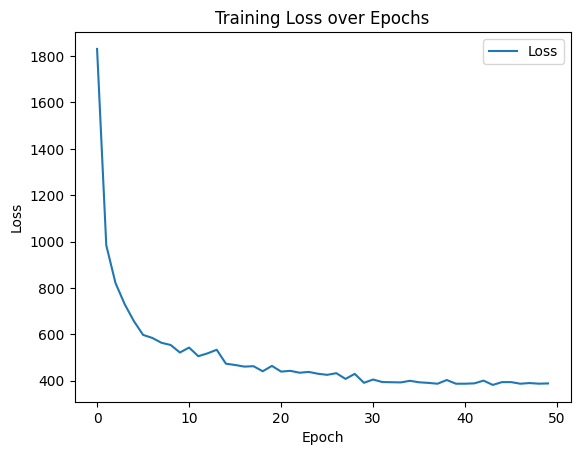

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

loss = [1831.144,983.6788,821.3764,729.7394,656.5769,597.1784,584.1101,563.1421
,553.593,521.1583,542.485,505.2527,517.492,533.0738,472.9458,467.3694
,460.388,462.0856,440.2953,463.4025,438.8215,442.1291,433.9256,437.4074
,429.5755,424.8397,431.9702,407.3062,429.0812,390.573,404.607,393.6931
,392.9229,392.1547,399.1457,392.6478,390.0974,386.544,402.488,386.5604
,386.5604,388.1058,399.8875,381.3295,393.415,393.4151,386.544,389.4,386.684,387.774]

plt.plot(loss, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

1/1 [==============================] - 1s 1s/step
MSE value: 90.659
PSNR value: 28.557 dB
SSIM: 0.81


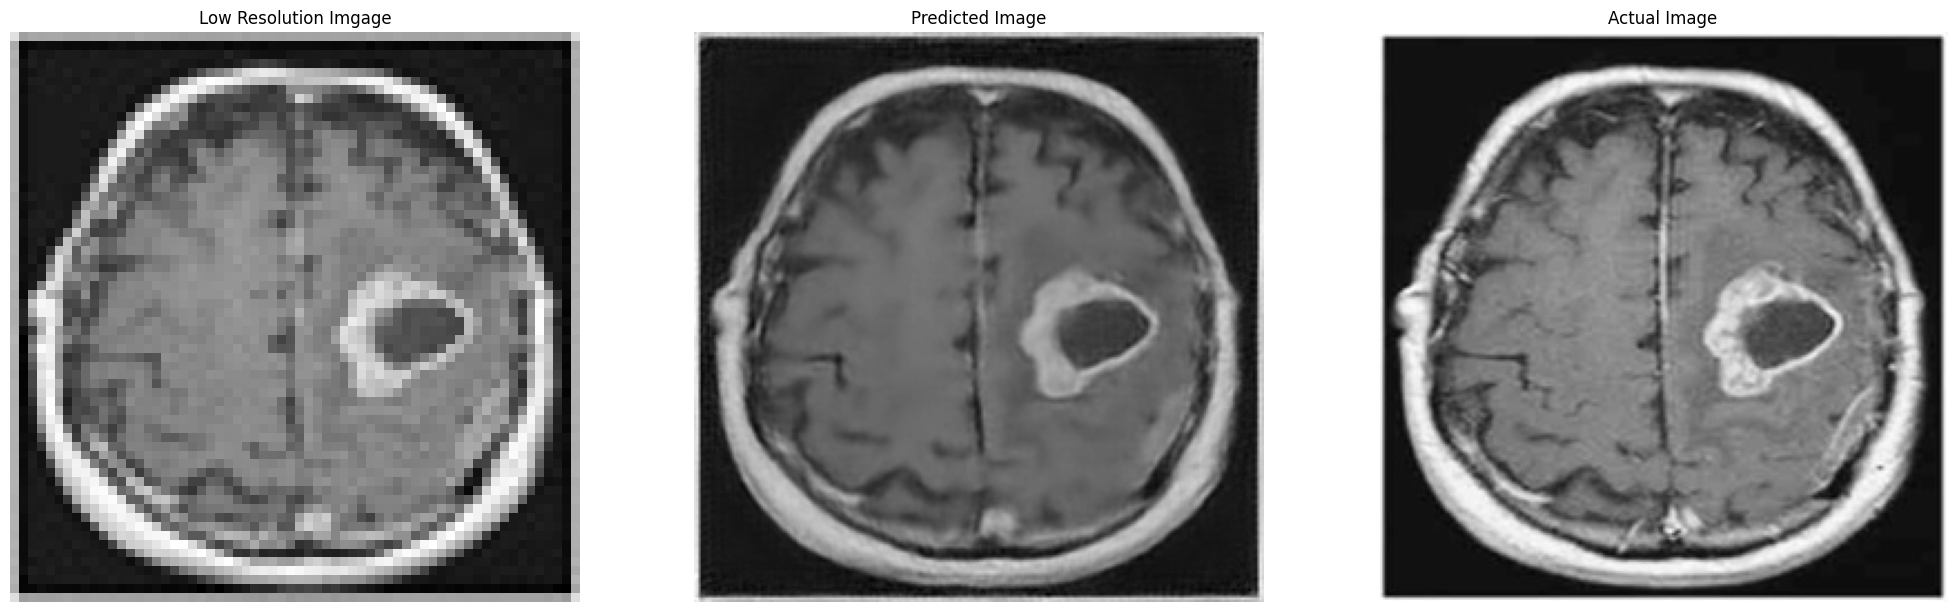

In [ ]:
# load the model from the directory
from keras.models import load_model
model = load_model('/content/drive/MyDrive/new3.h5')

from skimage import img_as_ubyte
import matplotlib.pyplot as plt

def predict_hr_image(model, lr_image_path):
    # 1. Load and preprocess the LR image
    lr_image = io.imread(lr_image_path).astype(np.float32)

    lr_image_resized = transform.resize(lr_image, (64, 64, 1))

    # Expand the dimensions to match the batch size
    lr_image_resized = np.expand_dims(lr_image_resized, axis=0)

    # 2. Predict using the model
    predicted_hr_image = model.predict(lr_image_resized)

    # Reshape the output to remove batch dimension
    predicted_hr_image = predicted_hr_image.reshape((256, 256))

    return predicted_hr_image

# Use the function
from skimage import io, transform
import numpy as np

lr_image_path = "/content/pred56.jpg"
predicted_hr_image = predict_hr_image(model, lr_image_path)

#plt.imshow(predicted_hr_image, cmap ="gray")
#plt.axis("off")

import cv2
import numpy as np
from PIL import Image

def compute_psnr(img1_path):
    # Read the images
    img1 = Image.open(img1_path).convert("L")

    # Normalize the pixel values to [0, 255]
    img2 = predicted_hr_image
    img2= img_as_ubyte((img2 - img2.min()) / (img2.max() - img2.min()))


    # Ensure the images are the same size and type
    assert img1.size == img2.shape, "Images must be of the same shape and channels."

    # Compute the MSE (Mean Squared Error)
    mse = np.mean((img1 - img2) ** 2)

    # Avoid division by zero
    if mse == 0:
        return float('inf')

    # Compute the PSNR value
    max_pixel_value = 255.0
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))

    return psnr, mse

img1_path = '/content/pred56 64.jpg'


psnr_value = compute_psnr(img1_path)
print(f"MSE value: {psnr_value[1]:.3f}")
print(f"PSNR value: {psnr_value[0]:.3f} dB")

import cv2
from google.colab.patches import cv2_imshow
from skimage.metrics import structural_similarity as ssim

img1 = cv2.imread(img1_path)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = predicted_hr_image
img3 = cv2.imread('/content/pred56 64.jpg')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

# Calculate SSIM
ssim_value, _ = ssim(img1, img2, full=True)

# Print the SSIM value
print(f"SSIM: {ssim_value:.2f}")

pics = [img3, img2, img1]
title = ["Low Resolution Imgage", "Predicted Image", "Actual Image"]

fig, axes = plt.subplots(1, len(pics), figsize=(25,25))

for i, ax in enumerate(axes):
    ax.imshow(pics[i], cmap="gray")
    ax.set_title(title[i])
    ax.axis("off")

plt.show()

###**model 2**

In [ ]:
from keras.layers import Input, Conv2D, Conv2DTranspose, Dropout
from keras.models import Model
from keras.optimizers import Adam

def fsrcnn(input_shape):
    inputs = Input(input_shape)

    # Feature extraction
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(inputs)

    # Shrinking
    x = Conv2D(128, (1, 1), padding='same', activation='relu')(x)
    x = Dropout(0.2)(x)

    # mapping
    for _ in range(10):
        x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)

    # Expanding
    x = Conv2D(256, (1, 1), padding='same', activation='relu')(x)

    # Deconvolution
    outputs = Conv2DTranspose(1, (9, 9), strides=4, padding='same', activation='relu')(x)

    model = Model(inputs=inputs, outputs=outputs, name='FSRCNN_relu')
    return model

model = fsrcnn((64, 64, 1))
model.compile(optimizer=Adam(), loss='mean_squared_error')
model.summary()


Model: "FSRCNN_relu"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_65 (Conv2D)          (None, 64, 64, 256)       2560      
                                                                 
 conv2d_66 (Conv2D)          (None, 64, 64, 128)       32896     
                                                                 
 dropout_5 (Dropout)         (None, 64, 64, 128)       0         
                                                                 
 conv2d_67 (Conv2D)          (None, 64, 64, 256)       295168    
                                                                 
 conv2d_68 (Conv2D)          (None, 64, 64, 256)       590080    
                                                                 
 conv2d_69 (Conv2D)          (None, 64, 64, 256)       

In [ ]:
# Parameters
low_res_dir = '/content/drive/MyDrive/Down yes'
high_res_dir = '/content/drive/MyDrive/yes'
epochs = 50
batch_size = 8

# Load dataset
lr_images, hr_images = load_and_preprocess_images(low_res_dir, high_res_dir)


In [ ]:
steps_per_epoch = len(lr_images) // batch_size
print("steps perepoch is",steps_per_epoch)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
checkpoint_path = '/content/drive/MyDrive/new5 relu.h5'
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.3,
                              patience = 2, min_delta = 0.001,
                              mode = 'min', verbose = 1)

checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='loss',
                             save_best_only=True,
                             mode="auto",
                             verbose=1)


history = model.fit(x = lr_images, y= hr_images, steps_per_epoch=steps_per_epoch, epochs=epochs, callbacks = [reduce_lr,checkpoint])


steps perepoch is 187
Epoch 1/50
187/187 [==============================] - ETA: 0s - loss: 5946.5195
Epoch 1: loss improved from inf to 5946.51953, saving model to /content/drive/MyDrive/new5 relu.h5
187/187 [==============================] - 107s 213ms/step - loss: 5946.5195 - lr: 0.0010
Epoch 2/50
187/187 [==============================] - ETA: 0s - loss: 779.1340
Epoch 2: loss improved from 5946.51953 to 779.13403, saving model to /content/drive/MyDrive/new5 relu.h5
187/187 [==============================] - 39s 209ms/step - loss: 779.1340 - lr: 0.0010
Epoch 3/50
187/187 [==============================] - ETA: 0s - loss: 626.7001
Epoch 3: loss improved from 779.13403 to 626.70007, saving model to /content/drive/MyDrive/new5 relu.h5
187/187 [==============================] - 39s 211ms/step - loss: 626.7001 - lr: 0.0010
Epoch 4/50
187/187 [==============================] - ETA: 0s - loss: 593.1577
Epoch 4: loss improved from 626.70007 to 593.15765, saving model to /content/drive/MyDr


Epoch 45: ReduceLROnPlateau reducing learning rate to 1.434890747886719e-11.

Epoch 45: loss did not improve from 489.36435
187/187 [==============================] - 25s 134ms/step - loss: 506.8568 - lr: 4.7830e-11


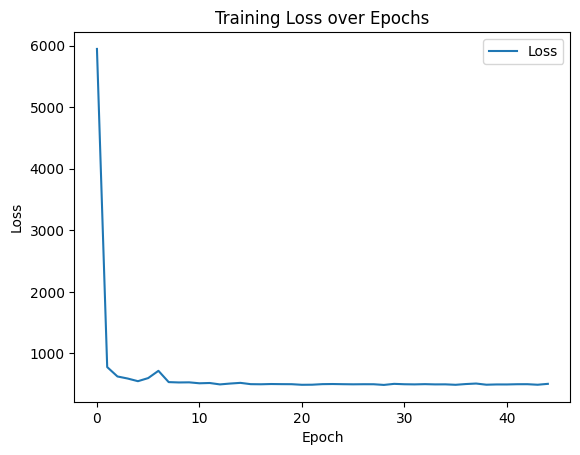

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

1/1 [==============================] - 0s 480ms/step
MSE value: 101.002
PSNR value: 28.088 dB
SSIM: 0.80


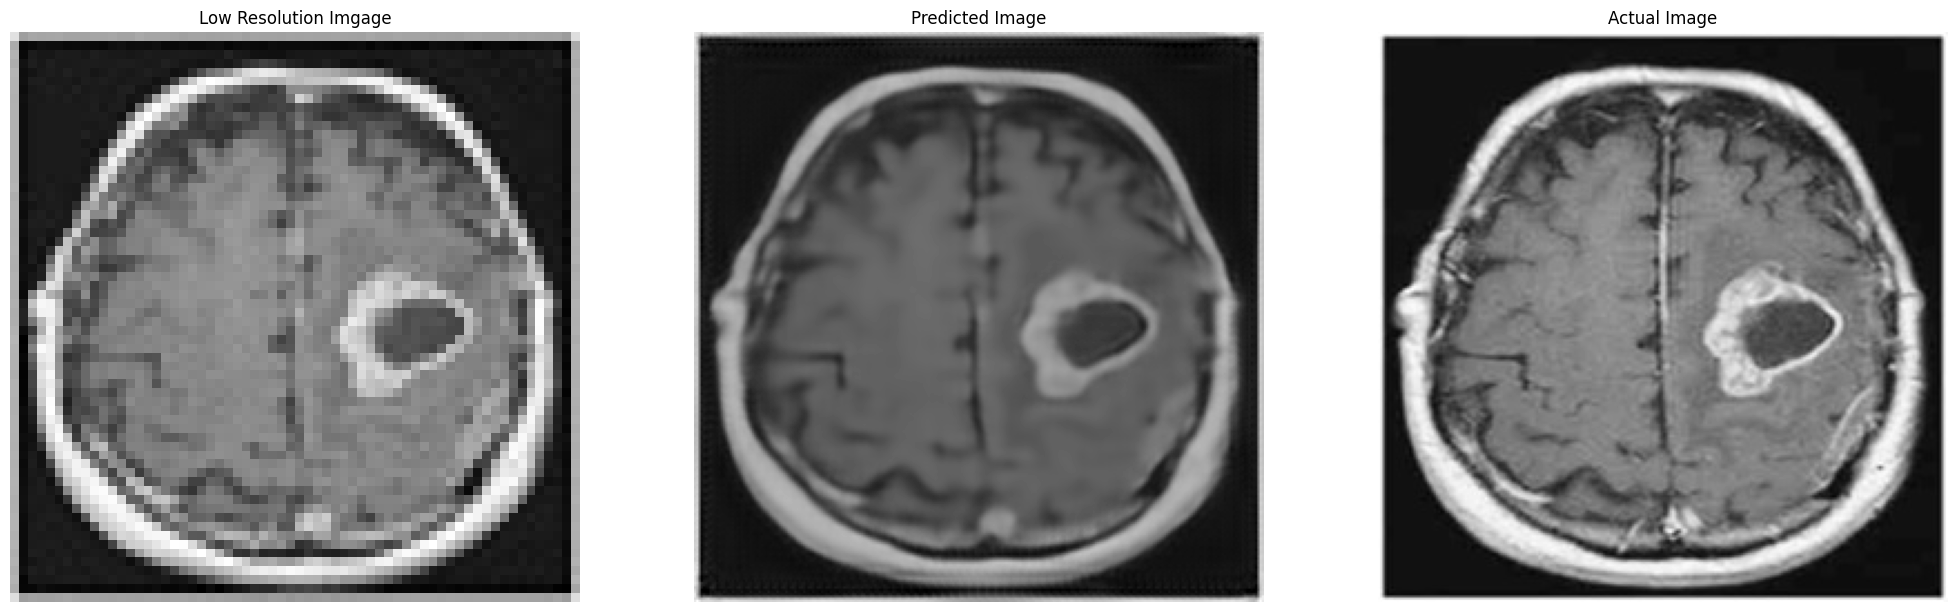

In [ ]:
# load the model from the directory
from keras.models import load_model
model = load_model('/content/drive/MyDrive/new5 relu.h5')

from skimage import img_as_ubyte
import matplotlib.pyplot as plt

def predict_hr_image(model, lr_image_path):
    # 1. Load and preprocess the LR image
    lr_image = io.imread(lr_image_path).astype(np.float32)

    lr_image_resized = transform.resize(lr_image, (64, 64, 1))

    # Expand the dimensions to match the batch size
    lr_image_resized = np.expand_dims(lr_image_resized, axis=0)

    # 2. Predict using the model
    predicted_hr_image = model.predict(lr_image_resized)

    # Reshape the output to remove batch dimension
    predicted_hr_image = predicted_hr_image.reshape((256, 256))

    return predicted_hr_image

# Use the function
from skimage import io, transform
import numpy as np

lr_image_path = "/content/pred56 64.jpg"
predicted_hr_image = predict_hr_image(model, lr_image_path)

#plt.imshow(predicted_hr_image, cmap ="gray")
#plt.axis("off")

import cv2
import numpy as np
from PIL import Image

def compute_psnr(img1_path):
    # Read the images
    img1 = Image.open(img1_path).convert("L")

    # Normalize the pixel values to [0, 255]
    img2 = predicted_hr_image
    img2= img_as_ubyte((img2 - img2.min()) / (img2.max() - img2.min()))


    # Ensure the images are the same size and type
    assert img1.size == img2.shape, "Images must be of the same shape and channels."

    # Compute the MSE (Mean Squared Error)
    mse = np.mean((img1 - img2) ** 2)

    # Avoid division by zero
    if mse == 0:
        return float('inf')

    # Compute the PSNR value
    max_pixel_value = 255.0
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))

    return psnr, mse

img1_path = '/content/pred56.jpg'


psnr_value = compute_psnr(img1_path)
print(f"MSE value: {psnr_value[1]:.3f}")
print(f"PSNR value: {psnr_value[0]:.3f} dB")

import cv2
from google.colab.patches import cv2_imshow
from skimage.metrics import structural_similarity as ssim

img1 = cv2.imread(img1_path)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = predicted_hr_image
img3 = cv2.imread('/content/pred56 64.jpg')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

# Calculate SSIM
ssim_value, _ = ssim(img1, img2, full=True)

# Print the SSIM value
print(f"SSIM: {ssim_value:.2f}")

pics = [img3, img2, img1]
title = ["Low Resolution Imgage", "Predicted Image", "Actual Image"]

fig, axes = plt.subplots(1, len(pics), figsize=(25,25))

for i, ax in enumerate(axes):
    ax.imshow(pics[i], cmap="gray")
    ax.set_title(title[i])
    ax.axis("off")

plt.show()

###**model3**

In [ ]:
from keras.layers import Input, Conv2D, Conv2DTranspose, Dropout, PReLU
from keras.models import Model
from keras.optimizers import Adam

def fsrcnn(input_shape):
    inputs = Input(input_shape)

    # Feature extraction with ReLU
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(inputs)

    # Shrinking with PReLU
    x = Conv2D(128, (1, 1), padding='same')(x)
    x = PReLU()(x)
    x = Dropout(0.2)(x)

    #mapping with ReLU
    for _ in range(10):
        x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)

    # Expanding with PReLU
    x = Conv2D(256, (1, 1), padding='same')(x)
    x = PReLU()(x)

    # Deconvolution with ReLU
    outputs = Conv2DTranspose(1, (9, 9), strides=4, padding='same')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

model = fsrcnn((64, 64, 1))
model.compile(optimizer=Adam(), loss='mean_squared_error')
model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_52 (Conv2D)          (None, 64, 64, 256)       2560      
                                                                 
 conv2d_53 (Conv2D)          (None, 64, 64, 128)       32896     
                                                                 
 p_re_lu_8 (PReLU)           (None, 64, 64, 128)       524288    
                                                                 
 dropout_4 (Dropout)         (None, 64, 64, 128)       0         
                                                                 
 conv2d_54 (Conv2D)          (None, 64, 64, 256)       295168    
                                                                 
 conv2d_55 (Conv2D)          (None, 64, 64, 256)       5900

In [ ]:
def paired_data_generator(lr_images, hr_images, batch_size):
    datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.1
    )

    seed = 1  # for the same augmentation transformations

    lr_gen = datagen.flow(lr_images, None, batch_size=batch_size, seed=seed)
    hr_gen = datagen.flow(hr_images, None, batch_size=batch_size, seed=seed)

    while True:
        lr_batch = lr_gen.next()
        hr_batch = hr_gen.next()
        yield lr_batch, hr_batch



In [ ]:
# Parameters
low_res_dir = '/content/drive/MyDrive/Down yes'
high_res_dir = '/content/drive/MyDrive/yes'
epochs = 50
batch_size = 16

# Load dataset
lr_images, hr_images = load_and_preprocess_images(low_res_dir, high_res_dir)

# Training with augmentation
steps_per_epoch = len(lr_images) // batch_size
augmented_data_gen = paired_data_generator(lr_images, hr_images, batch_size)
print("steps perepoch is",steps_per_epoch)

steps perepoch is 93


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint
checkpoint_path = '/content/drive/MyDrive/new5 linear.h5'
reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.3,
                              patience = 2, min_delta = 0.001,
                              mode = 'min', verbose = 1)

checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='loss',
                             save_best_only=True,
                             mode="auto",
                             verbose=1)


history = model.fit(augmented_data_gen, steps_per_epoch=steps_per_epoch, epochs=epochs, callbacks = [reduce_lr,checkpoint])


Epoch 1/50
93/93 [==============================] - ETA: 0s - loss: 6689.7891
Epoch 1: loss improved from inf to 6689.78906, saving model to /content/drive/MyDrive/new5 linear.h5
93/93 [==============================] - 34s 319ms/step - loss: 6689.7891 - lr: 0.0010
Epoch 2/50
93/93 [==============================] - ETA: 0s - loss: 1062.5457
Epoch 2: loss improved from 6689.78906 to 1062.54565, saving model to /content/drive/MyDrive/new5 linear.h5
93/93 [==============================] - 29s 309ms/step - loss: 1062.5457 - lr: 0.0010
Epoch 3/50
93/93 [==============================] - ETA: 0s - loss: 750.5006
Epoch 3: loss improved from 1062.54565 to 750.50061, saving model to /content/drive/MyDrive/new5 linear.h5
93/93 [==============================] - 29s 309ms/step - loss: 750.5006 - lr: 0.0010
Epoch 4/50
93/93 [==============================] - ETA: 0s - loss: 660.1005
Epoch 4: loss improved from 750.50061 to 660.10046, saving model to /content/drive/MyDrive/new5 linear.h5
93/93 [=

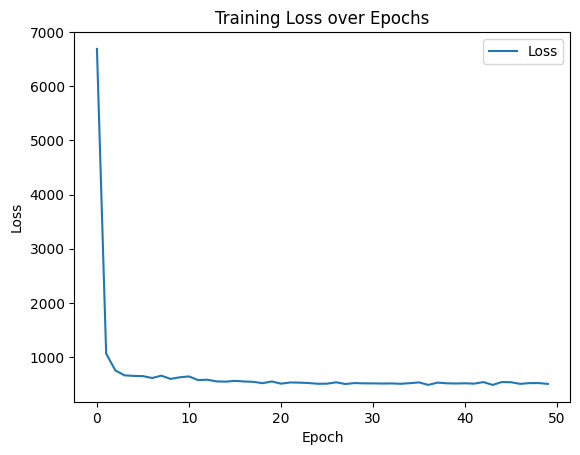

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

1/1 [==============================] - 0s 310ms/step
MSE value: 90.663
PSNR value: 28.557 dB
SSIM: 0.82


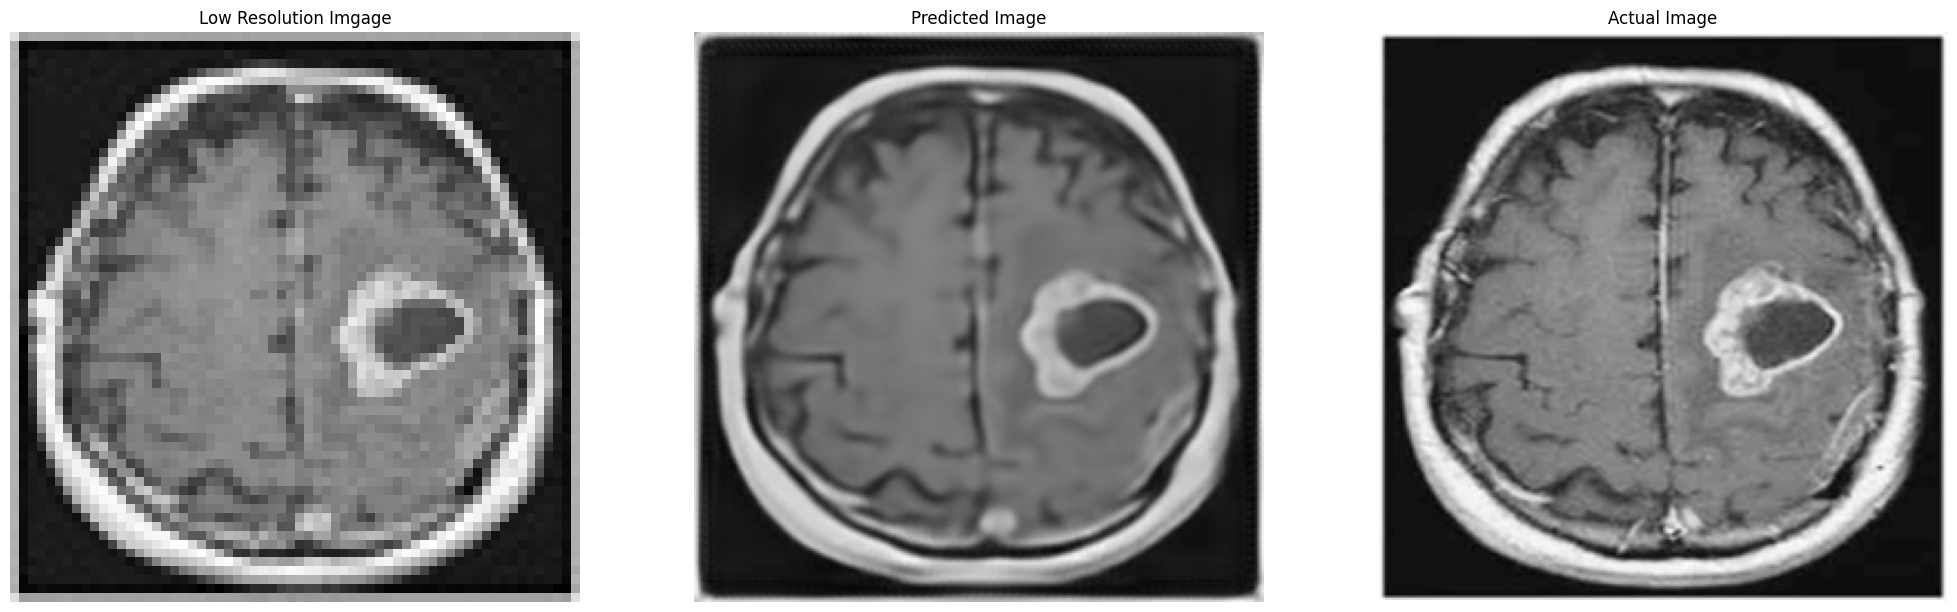

In [ ]:
# load the model from the directory
from keras.models import load_model
model = load_model('/content/drive/MyDrive/new5 hybrid.h5')

from skimage import img_as_ubyte
import matplotlib.pyplot as plt

def predict_hr_image(model, lr_image_path):
    # 1. Load and preprocess the LR image
    lr_image = io.imread(lr_image_path).astype(np.float32)

    lr_image_resized = transform.resize(lr_image, (64, 64, 1))

    # Expand the dimensions to match the batch size
    lr_image_resized = np.expand_dims(lr_image_resized, axis=0)

    # 2. Predict using the model
    predicted_hr_image = model.predict(lr_image_resized)

    # Reshape the output to remove batch dimension
    predicted_hr_image = predicted_hr_image.reshape((256, 256))

    return predicted_hr_image

# Use the function
from skimage import io, transform
import numpy as np

lr_image_path = "/content/pred56.jpg"
predicted_hr_image = predict_hr_image(model, lr_image_path)

#plt.imshow(predicted_hr_image, cmap ="gray")
#plt.axis("off")

import cv2
import numpy as np
from PIL import Image

def compute_psnr(img1_path):
    # Read the images
    img1 = Image.open(img1_path).convert("L")

    # Normalize the pixel values to [0, 255]
    img2 = predicted_hr_image
    img2= img_as_ubyte((img2 - img2.min()) / (img2.max() - img2.min()))


    # Ensure the images are the same size and type
    assert img1.size == img2.shape, "Images must be of the same shape and channels."

    # Compute the MSE (Mean Squared Error)
    mse = np.mean((img1 - img2) ** 2)

    # Avoid division by zero
    if mse == 0:
        return float('inf')

    # Compute the PSNR value
    max_pixel_value = 255.0
    psnr = 20 * np.log10(max_pixel_value / np.sqrt(mse))

    return psnr, mse

img1_path = '/content/pred56 64.jpg'


psnr_value = compute_psnr(img1_path)
print(f"MSE value: {psnr_value[1]:.3f}")
print(f"PSNR value: {psnr_value[0]:.3f} dB")

import cv2
from google.colab.patches import cv2_imshow
from skimage.metrics import structural_similarity as ssim

img1 = cv2.imread(img1_path)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
img2 = predicted_hr_image
img3 = cv2.imread('/content/pred56 64.jpg')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY)

# Calculate SSIM
ssim_value, _ = ssim(img1, img2, full=True)

# Print the SSIM value
print(f"SSIM: {ssim_value:.2f}")

pics = [img3, img2, img1]
title = ["Low Resolution Imgage", "Predicted Image", "Actual Image"]

fig, axes = plt.subplots(1, len(pics), figsize=(25,25))

for i, ax in enumerate(axes):
    ax.imshow(pics[i], cmap="gray")
    ax.set_title(title[i])
    ax.axis("off")

plt.show()

###**Bicubic**

SSIM: 0.7806
PSNR: 21.8892


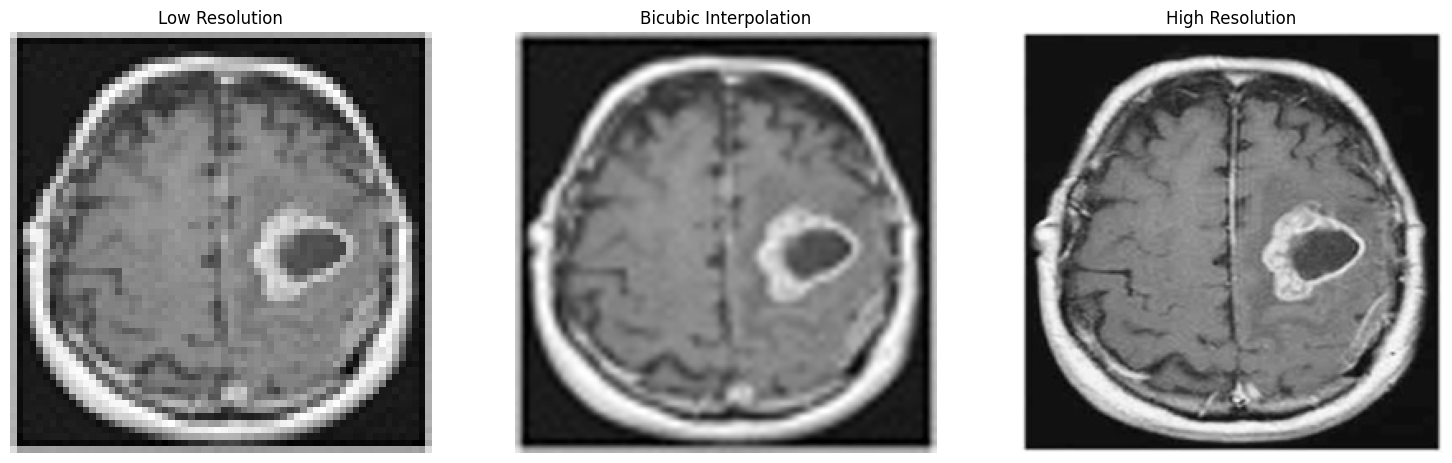

In [ ]:
import numpy as np
from PIL import Image
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr

def calculate_metrics(original, interpolated):
    # SSIM, PSNR, and MSE calculation
    ssim_value, _ = ssim(original, interpolated, full=True)
    psnr_value = psnr(original, interpolated)
    mse_value = np.mean((original - interpolated) ** 2)

    return ssim_value, psnr_value

def main():
    # Load the low-resolution image
    low_res_path = "/content/pred56 64.jpg"
    lr_image = Image.open(low_res_path).convert("L")
    lr_array = np.array(lr_image)

    # Perform bicubic interpolation using Pillow's resize method
    bicubic_result = lr_image.resize((256, 256), resample=Image.BICUBIC)
    bicubic_array = np.array(bicubic_result)

    # Load the high-resolution reference image for comparison
    high_res_path = "/content/pred56.jpg"
    hr_image = Image.open(high_res_path).convert("L")
    hr_array = np.array(hr_image)

    # Calculate SSIM, PSNR, and MSE
    ssim_value, psnr_value = calculate_metrics(hr_array, bicubic_array)

    print(f"SSIM: {ssim_value:.4f}")
    print(f"PSNR: {psnr_value:.4f}")

    # Plot images side by side
    plt.figure(figsize=(25, 25))

    plt.subplot(1, 4, 3)
    plt.imshow(hr_array, cmap='gray')
    plt.axis("off")
    plt.title('High Resolution')

    plt.subplot(1, 4, 1)
    plt.imshow(lr_array, cmap='gray')
    plt.axis("off")
    plt.title('Low Resolution')

    plt.subplot(1, 4, 2)
    plt.imshow(np.array(bicubic_result), cmap='gray')
    plt.axis("off")
    plt.title('Bicubic Interpolation')

    plt.show()

if __name__ == "__main__":
    main()
